<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [342]:
%%capture
pip install pyswarms

In [343]:
%%capture
pip install scipy

In [344]:
from scipy import stats
import numpy as np
import pandas as pd
import math
import csv
import locale
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps

In [345]:
!dpkg-reconfigure locales

Generating locales (this might take a while)...
  en_US.UTF-8... done
  pt_BR.ISO-8859-1... done
Generation complete.


In [346]:
# Install locale pt_BR
!/usr/share/locales/install-language-pack pt_BR

Generating locales (this might take a while)...
Generation complete.
dpkg-trigger: error: must be called from a maintainer script (or with a --by-package option)

Type dpkg-trigger --help for help about this utility.


In [347]:
print(locale.getlocale())

('pt_BR', 'ISO8859-1')


In [348]:
locale.setlocale(locale.LC_ALL, 'pt_BR.iso88591')

'pt_BR.iso88591'

In [349]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [350]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 15000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 15000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

VALOR_DIMENSOES = int(DIAS_OBSERVADOS / 30)

ALGORITMO = 'pso'

# Configuraçaõ dos cerarios utulidados para os testes: primeiro_cenario, segundo_cenario, terceiro_cenario, quarto_cenario
CENARIO = 'primeiro_cenario'

LINK_ARQUIVO_PRINCIPAL = f'/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_{ALGORITMO}/Resultados_{CENARIO}/'
NOME_ARQUIVO_PRINCIPAL = f'melhor_custo_{ALGORITMO}_{CENARIO}'
NOME_ARQUIVO_TEMPO_SEVERIDADE = '_tempo_severidade'
NOME_ARQUIVO_PARAMETROS = 'parametros'

# Constante para configuração dos cenarios de teste. de 01 a 04
CENARIO_TESTE = f'{CENARIO}'

In [351]:
print(LINK_ARQUIVO_PRINCIPAL)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_primeiro_cenario/


In [352]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        for i in range(len(self.T) - 1):
            for tt in range(int(self.T[i]), int(self.T[i + 1])):
                b = tt - self.fator[0][i] * self.T[i]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))
            # Adiciona nan ao final do ciclo
            self.u.append(float('nan'))

    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [353]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [354]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [355]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [356]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [357]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [358]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [359]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    # Dicionario definido pelo cliente
    dist = {0.2: 2000, 0.4: 4000, 0.5: 9000, 0.9: 12000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.2 or si > 0.9 else np.interp(si, [0.2, 0.4, 0.5, 0.9], [2000, 4000, 9000, 12000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [360]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
df = pd.read_csv(f'/content/drive/MyDrive/datasets/Cenarios/{CENARIO_TESTE}.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [361]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [362]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return (-1)*fitness

In [363]:
# Parâmetros do PSO
num_particles = 100
max_iterations = 50
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 3, 1])
bounds = (lb, ub)

# Registre o tempo de início de convergência para a primeira etapa
start_time_first_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Registre o tempo de término
end_time_first_stage = time.time()

# Calcule o tempo total de convergência
convergence_time_first_stage = end_time_first_stage - start_time_first_stage

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

2024-03-15 18:27:42,957 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=-1.27e-23
2024-03-15 18:27:43,214 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -1.271181889377993e-23, best pos: [149.17635305   2.9924384    0.49613284]


In [364]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)
print('')
print("Tempo de Convergência para a primeira etapa:", convergence_time_first_stage, "segundos")

lamb: 149.1763530473897
beta: 2.992438397292381
theta: 0.49613284302311

Tempo de Convergência para a primeira etapa: 0.009799957275390625 segundos


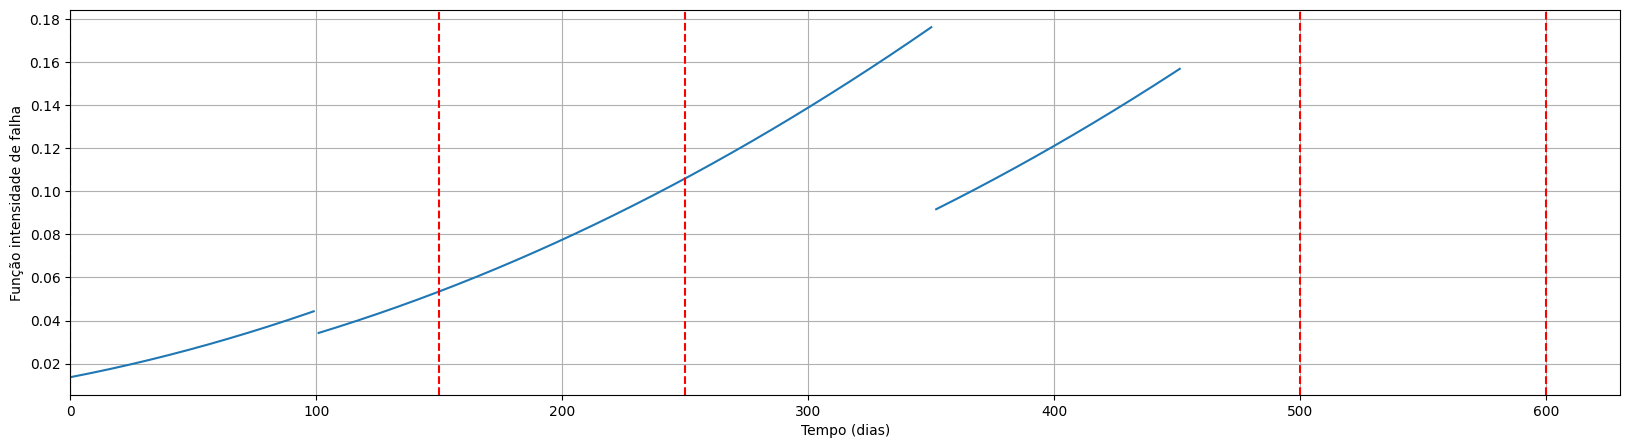

Fator ajuste:  [0.18000180275605104, 0.21969188768759063, 0.3601487546089954, 0.09446248159231474]


In [365]:
# lamb = 149.46611911427442
# beta = 3.7082881597847184
# theta = 0.8860147939929904

solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [366]:
# Nome do arquivo CSV para salvar os resultados dos parametros
nome_arquivo_parametros = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PARAMETROS}.csv'

In [367]:
# Gravar os valores de Lambda, Beta e Theta em um arquivo separado
melhores_parametros = []

try:
    with open(nome_arquivo_parametros, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_parametros.append(linha[1])
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução


# Criar uma lista com os valores atuais
valores_atuais = [len(melhores_parametros), lamb, beta, theta, convergence_time_first_stage]

# Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
with open(nome_arquivo_parametros, 'a+', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Se o arquivo estiver vazio, escreva o cabeçalho
    if arquivo_csv.tell() == 0:
        writer.writerow(['Index', 'Lambda', 'Beta', 'Theta', 'Convergencia_Primeira_Etapa'])

    # Escrever os valores atuais
    writer.writerow(valores_atuais)

In [368]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo_parametros, sep=",")
resultado.head(10)

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
0,0,149.778989,4.015795,0.966886,0.011218
1,1,149.997314,3.820812,0.954017,0.011207
2,2,149.724153,4.016686,0.979311,0.009828
3,3,149.853125,3.979660,0.991880,0.009296
4,4,149.977591,3.777460,0.893294,0.013695
5,5,149.769561,4.030911,0.987483,0.009681
6,6,149.466119,3.708288,0.886015,0.009480
7,7,124.477154,1.999610,0.264075,0.006245
8,8,149.176353,2.992438,0.496133,0.009800


In [369]:
resultado.describe()

,Index,Lambda,Beta,Theta,Convergencia_Primeira_Etapa
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,4.000000,146.913373,3.593518,0.824344,0.010050
std,2.738613,8.417495,0.679919,0.261250,0.001988
min,0.000000,124.477154,1.999610,0.264075,0.006245
25%,2.000000,149.466119,3.708288,0.886015,0.009480
50%,4.000000,149.769561,3.820812,0.954017,0.009800
75%,6.000000,149.853125,4.015795,0.979311,0.011207
max,8.000000,149.997314,4.030911,0.991880,0.013695


In [370]:
param_primeira_etapa = ['Lambda', 'Beta', 'Theta']
Lambda = ['Lambda']
Beta = ['Beta']
Theta = ['Theta']

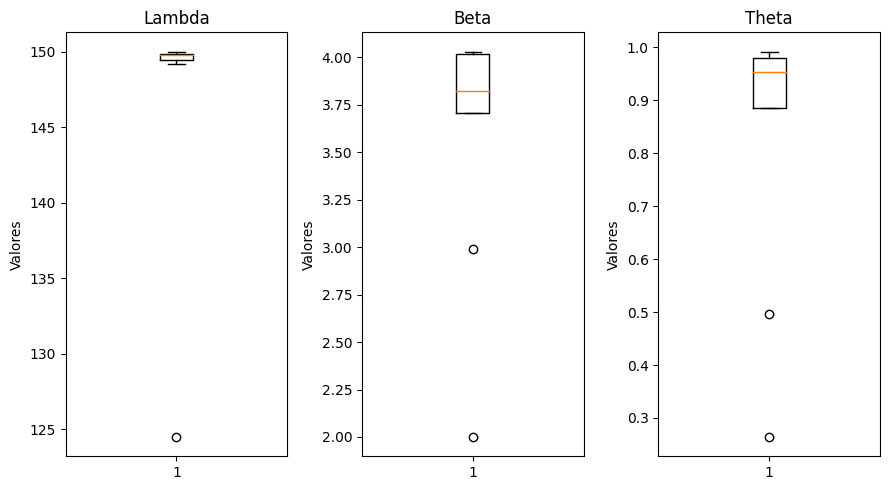

In [371]:
# Cria uma grafico para os parametros Lambda, Beta e Theta
# Tamanho da figura
plt.figure(figsize=(9, 5))

# Itera sobre as colunas e cria um boxplot para cada uma
for i, coluna in enumerate(param_primeira_etapa):
    plt.subplot(1, 3, i + 1)  # 1 linhas, 3 colunas de gráficos
    plt.boxplot(resultado[coluna])
    plt.title(coluna)
    plt.ylabel('Valores')

# Ajusta o layout
plt.tight_layout()
plt.show()

In [372]:
# Configurar a formatação da moeda
def format_currency(value):
    return locale.currency(value, grouping=True)

In [373]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1:0.2, 3:0.4, 5:0.5, 7:0.9}

    results = [] # Lista para armazenar os resultados das funções objetivo

    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [374]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
max_bound = np.array([1.3] * dimensions)  # Limite superior dos valores em x
bounds = (min_bound, max_bound)

# Registre o tempo de início de convergência para a segunda etapa
start_time_second_stage = time.time()

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

# Registre o tempo de término
end_time_second_stage = time.time()

# Agora, você pode calcular os outros valores relacionados à melhor solução
# Primeiro, você precisa transformar a melhor posição em uma lista (se necessário)
best_position_list = best_position.tolist()

pbest_cost = optimizer.swarm.pbest_cost

gbest_cost = optimizer.cost_history[-1]  # O último valor registrado no histórico de custos

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2024-03-15 18:27:45,816 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=3.21e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 95, 155, 218, 397, 450, 510, 576]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.25915091972333637, 1.0047030085756863, 2.698744891535935, 16.339016652884432, 23.417237746051004, 33.701086865837965, 48.1577925792418, 54.2593150208042]
Custo =  13728.99901556324


Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 95, 127, 152, 335, 420, 488]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.25915091972333637, 0.5627153653865731, 0.9

pyswarms.single.global_best:  31%|███       |31/100, best_cost=3.21e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 64, 150, 367, 573, 638]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.0794728898364077, 0.9192765479057408, 13.30917557975916, 48.86056243081643, 66.51823796526882, 55.927011105894636]
Custo =  11917.406129874289


Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 63, 361, 513]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.07581453031373277, 13.413678092415617, 35.74743349668159, 55.850642014993795]
Custo =  6434.083345868426


Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 63, 90, 215, 244, 274, 516]
Severidade para cada su

pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=1.79e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 65, 395, 456]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.08324693224449906, 17.60601994808431, 25.84891574843395, 56.32152495488914]
Custo =  6100.37783994309


Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 1, 63, 307, 396, 451]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 3.1285038861667167e-07, 0.07547494819937109, 8.194465842058083, 16.54202506460869, 23.891801225198673, 55.178308114308955]
Custo =  9191.120884705366


Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 61, 574]
Severidade para cada subsistema: [0.2, 0.2

pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=1.79e+3<ipython-input-373-f2a244820fa5>:79: RuntimeWarning: divide by zero encountered in scalar divide
  Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))
pyswarms.single.global_best:  56%|█████▌    |56/100, best_cost=1.79e+3



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 246]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 4.467481047013181, 58.35476433971082]
Custo =  2569.54664128536


Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 181, 306, 458, 515, 577]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.7836135170253284, 7.685622299658857, 24.916287512508, 34.94131874167688, 48.65789220097974, 54.513961371526776]
Custo =  12526.826342104376


Número de ciclos de manutenção: 0 5
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 5


Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 60, 245, 302, 577, 63

pyswarms.single.global_best:  72%|███████▏  |72/100, best_cost=1.79e+3



Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 510]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 39.588920264474986, 60.28999078267306]
Custo =  4640.702218328028


Número de ciclos de manutenção: 0 5
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 5


Número de ciclos de manutenção: 1 5
Tempos para manutenções preventivas: [0, 390]
Severidade para cada subsistema: [0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 17.73935883179251, 57.821093809020866]
Custo =  3559.9161164460593


Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 183, 392]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.8432413804620789, 16.21238394037825, 56.0373412

pyswarms.single.global_best:  88%|████████▊ |88/100, best_cost=1.79e+3



Número de ciclos de manutenção: 2 5
Tempos para manutenções preventivas: [0, 185, 212]
Severidade para cada subsistema: [0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9041818974339435, 2.7020356196021615, 58.74050440115246]
Custo =  2854.1203675216175


Número de ciclos de manutenção: 0 5
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 5


Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 31, 184, 452]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.009081230428447565, 1.788060561488717, 24.92677544248, 56.051684158364296]
Custo =  4726.996991103659


Número de ciclos de manutenção: 0 5
Tempos para manutenções preventivas: [0]
Severidade para cada subsistema: []
Número de Sisemas: 5


Número de

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=1.79e+3
2024-03-15 18:27:47,270 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20914142 1.13073591 0.14042324 0.30194    0.574218   0.65167729
 0.20630859 1.0523121  1.10240927 0.6474595  0.48446558 0.64195418
 0.46562114 1.14907594 1.11206021 1.09159682 0.73586473 0.12082606
 1.117676   0.45290259 1.02765314 0.76080482 0.30930071 0.18829759]
2024-03-15 18:27:47,275 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 4, 61, 181, 243, 422, 540]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9813633905212215e-05, 0.06757466014697686, 1.635450400866951, 3.7718313007556405, 19.570993819535712, 40.222231424709626, 54.669262422557345]
Custo =  8937.038065898092


Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 66, 245, 423]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.08713845131027981, 4.108119492984678, 19.943610875645803, 55.52092308817352]
Custo =  4770.247496500235


Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,301 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20578011 1.10394244 1.15656032 0.29990198 0.57424995 0.64843425
 0.20631119 0.16949234 1.11504679 0.6673343  0.48447154 0.64354626
 0.46566558 1.13443227 1.11234955 1.09059288 0.71949596 0.12011724
 1.11784066 0.45290841 1.02644126 0.76345526 0.24390865 0.18867038]
2024-03-15 18:27:47,305 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 63, 213, 390]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.07581453031373277, 2.6865937892103786, 15.668330739856719, 55.75006571708508]
Custo =  4308.159883176557


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20611329 1.00957221 1.26335358 0.297682   0.57425057 0.65044679
 0.20630876 0.10759513 1.1117249  0.68932508 0.48447038 0.59213805
 0.46562588 1.13677637 1.11155108 1.09085074 0.71706621 0.12008758
 1.11828275 0.45290166 1.02635572 0.77285949 0.24771608 0.18886796]
2024-03-15 18:27:47,337 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 64, 213, 391, 602]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.0794728898364077, 2.683894012145057, 15.7884407426231, 56.309908248830034, 55.78132043763005]
Custo =  7295.60131643858


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,377 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20657321 0.81179158 0.08513261 0.2958703  0.57424225 0.65250504
 0.20630656 0.04598119 1.10701028 0.70564375 0.48446911 0.54592981
 0.46558974 1.13935937 1.11085214 1.091249   0.71878124 0.12022249
 1.11868051 0.4528957  1.02656754 0.77951553 0.267602   0.18897859]
2024-03-15 18:27:47,381 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 1, 213, 302, 392, 454, 605]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 3.1285038861667167e-07, 2.8992973449394257, 7.456277851382078, 15.691377860727714, 23.97511120069388, 56.172495312021596, 54.845124607858544]
Custo =  13229.978703141453


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,398 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.2073182  0.51245454 0.46122386 0.29462412 0.57422915 0.65430341
 0.20630471 1.23299178 1.10162264 0.70399238 0.48446718 0.52660003
 0.46556333 1.14419838 1.11037801 1.09161819 0.72089741 0.12046122
 1.11881547 0.45289048 1.0268707  0.78350843 0.29562516 0.18894974]
2024-03-15 18:27:47,400 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 213, 392, 517, 540, 607]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.903148342469915, 16.13116638670218, 35.76043033083951, 40.48946061071534, 56.84361408364925, 54.97977202574441]
Custo =  14275.582802539197


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,415 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20814283 0.20464438 1.00558516 0.29390965 0.57421655 0.65560868
 0.20630353 0.98202703 1.09690878 0.70226305 0.48446538 0.5232509
 0.46555347 1.14943189 1.11019986 1.09194932 0.72671051 0.12074248
 1.11869484 0.45288815 1.02727391 0.78629074 0.32151365 0.18887265]
2024-03-15 18:27:47,422 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 30, 213, 393, 420, 452, 512, 542, 608]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.008232487100087591, 2.7912051329987446, 16.14335779509187, 19.442800314001595, 23.94271479457596, 34.311427856532475, 40.454249079007724, 56.64419938875367, 54.51093289029155]
Custo =  18735.8482449551


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,473 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20915493 1.21532887 0.37806499 0.29446889 0.57420551 0.65677938
 0.20630247 0.62894165 1.09397554 0.69575219 0.48446377 0.52094962
 0.46556305 1.15410744 1.11027045 1.09221456 0.73416106 0.12100485
 1.11843571 0.45288656 1.02768576 0.78519808 0.34288303 0.18871434]
2024-03-15 18:27:47,478 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 32, 212, 394, 544, 607]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.009986315612474421, 2.7447063416739654, 16.263648687203318, 41.51891959033052, 56.98943714713204, 55.1255950892272]
Custo =  11393.669085769765


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,508 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.21006326 0.80781159 1.18142306 0.29598165 0.57419633 0.65701991
 0.20630253 0.2507824  1.09149807 0.68512136 0.48446248 0.54445511
 0.46558094 1.1570257  1.11085026 1.09243161 0.74115875 0.12119988
 1.11812677 0.45288879 1.02805482 0.77753927 0.35865661 0.18846901]
2024-03-15 18:27:47,510 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 1, 35, 67, 212, 243, 308, 395, 451, 545, 604]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 3.1285038861667167e-07, 0.012952560523338787, 0.08159000636530431, 2.6282129849634477, 3.8302806760262227, 7.572707389149736, 15.725688151377359, 23.193928194334973, 40.67995251405377, 55.10595056958476, 54.04562940269415]
Custo =  17431.160562794183


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,525 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.21076491 0.4048385  0.70900136 0.29816109 0.57419189 0.65660665
 0.20630284 1.22623427 1.0916014  0.66506041 0.48446207 0.57355019
 0.46560003 1.15883984 1.11149646 1.09239681 0.74702949 0.12128129
 1.11781544 0.45289215 1.02835122 0.76593481 0.36759356 0.18824353]
2024-03-15 18:27:47,528 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 37, 98, 211, 246, 395, 420, 546, 601]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.015419977946234351, 0.259091674065315, 2.5154963496810234, 3.8876295647550427, 15.938684710768944, 19.00690672254859, 41.29360651751631, 54.68377344464493, 54.41987207604942]
Custo =  12578.782292683376


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,551 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.21092144 1.24578657 0.40622189 0.30099928 0.57419468 0.65501515
 0.20630342 0.76661778 1.09305785 0.64435627 0.48446269 0.60133023
 0.46561964 1.15913839 1.11208946 1.09224903 0.75091082 0.12122298
 1.11749476 0.45289737 1.02850359 0.75543377 0.36282525 0.18805606]
2024-03-15 18:27:47,556 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 38, 91, 210, 248, 304, 396, 454, 512, 546]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.01670097372294326, 0.20628761126179343, 2.4923495290514217, 3.9911629723014483, 7.211596807227162, 15.779891612390738, 23.592025571920928, 33.65095436640858, 40.67152146002311, 53.792738999224035]
Custo =  14945.669294961877


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,602 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.21092945 0.70037244 0.20832276 0.3038073  0.57419918 0.65306907
 0.20630544 0.23276474 1.09666939 0.62612995 0.4844638  0.63176945
 0.46563757 1.1580451  1.11261489 1.09205553 0.75398472 0.12112796
 1.11725721 0.45290238 1.02858488 0.74670855 0.34738381 0.18792632]
2024-03-15 18:27:47,607 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 5, 210, 395, 546]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 3.8633261907778527e-05, 2.7638229133526795, 16.491573692195793, 42.08208814949272, 55.203305688693646]
Custo =  7973.140605262785


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,651 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.21075945 0.18275607 0.15081949 0.30629882 0.57420525 0.65113939
 0.20630749 1.15737292 1.10050034 0.61599153 0.48446492 0.66005273
 0.46565308 1.15590319 1.11300443 1.09185338 0.75436126 0.1209682
 1.11715479 0.45290692 1.02861762 0.74184225 0.32929596 0.18786549]
2024-03-15 18:27:47,655 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 61, 210, 303, 395, 456, 545]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.06883768377232906, 2.5779009887712316, 7.316430539913823, 15.83699942864012, 24.07989522898976, 40.77649771817751, 54.12045871070915]
Custo =  11084.334162185176


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,683 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.21021174 0.89589678 0.22823969 0.30839011 0.57421245 0.64941872
 0.20630952 0.68022646 1.10408047 0.61468784 0.48446608 0.68213307
 0.46565799 1.15285841 1.11329274 1.09161673 0.75193914 0.12079288
 1.11706704 0.45291039 1.02837176 0.73849377 0.30707681 0.18782954]
2024-03-15 18:27:47,690 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 210, 395, 516, 544]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.782498143744606, 16.51024892258772, 35.56716532484688, 41.362956772203155, 54.92894964981843]
Custo =  10556.881165228326


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,717 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20939942 0.28103167 0.42316776 0.30886173 0.57422004 0.64813658
 0.20631113 0.22681979 1.10704494 0.62069774 0.48446698 0.69300855
 0.46565767 1.14999544 1.11347169 1.09139925 0.74563649 0.12063708
 1.11711371 0.45291194 1.02811353 0.73819867 0.28750386 0.18789313]
2024-03-15 18:27:47,722 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 1, 95, 210, 395, 456, 543]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 3.1285038861667167e-07, 0.25838065833398866, 2.507423462450714, 16.23517424129383, 24.47807004164347, 40.72641925102316, 54.513733758579754]
Custo =  12044.613472329273


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,756 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20859537 0.91897758 0.72354133 0.30722606 0.57422671 0.64731939
 0.20631216 1.17039196 1.10849133 0.63353944 0.48446742 0.69416943
 0.46564801 1.14722606 1.11346131 1.09124551 0.73877616 0.12049876
 1.11719416 0.45291314 1.02782893 0.74020702 0.27627278 0.18797217]
2024-03-15 18:27:47,762 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 35, 68, 211, 394, 542]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.013057655388740205, 0.08543353251879168, 2.587575376303903, 16.148231477974154, 40.9465483191164, 54.954475514594975]
Custo =  7739.22876446034


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,785 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20798222 0.19495207 0.98545722 0.30556518 0.57423082 0.6468752
 0.20631271 0.69781273 1.10976807 0.64710317 0.48446769 0.68470448
 0.4656333  1.14517436 1.11315157 1.09110772 0.73236656 0.1204201
 1.11737548 0.45291233 1.02752667 0.74649245 0.27190864 0.18811217]
2024-03-15 18:27:47,795 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 450, 511, 542]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 23.81639781345871, 34.29597244681548, 40.632985893405525, 54.6409130888841]
Custo =  12757.148838193754


pyswarms.single.global_best:   0%|          |0/1<ipython-input-373-f2a244820fa5>:82: RuntimeWarning: divide by zero encountered in scalar divide
  Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,832 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20798222 0.19495207 0.98545722 0.30556518 0.57423082 0.6468752
 0.20631271 0.69781273 1.10976807 0.64710317 0.48446769 0.68470448
 0.4656333  1.14517436 1.11315157 1.09110772 0.73236656 0.1204201
 1.11737548 0.45291233 1.02752667 0.74649245 0.27190864 0.18811217]
2024-03-15 18:27:47,838 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 2, 212, 394, 541, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.48971947559441e-06, 2.8549262235044917, 16.373868569033842, 40.94505667900758, 55.17288893352999, 55.17288893352999]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 32, 91, 212, 245, 393, 513, 541, 601]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.009986315612474421, 0.2085073462869824, 2.5682568806295887, 3.86048553435894, 15.717199702559434, 34.40838531066751, 40.13919249602511, 54.63643541173036, 54.372534043134856]
Custo =  13434.5342452445


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,871 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20750586 1.07709153 1.16592331 0.30204489 0.57422955 0.64788839
 0.2063124  1.18250412 1.10934824 0.66183161 0.48446742 0.64674889
 0.46560348 1.14454362 1.11244197 1.09113083 0.72608017 0.12032964
 1.11777167 0.45290745 1.0271794  0.75919232 0.28117414 0.18839446]
2024-03-15 18:27:47,873 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,899 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.2076362  0.09678257 1.02307072 0.30074025 0.57422515 0.64854202
 0.20631114 0.70080364 1.10854992 0.66194826 0.4844668  0.62701437
 0.46559267 1.14596636 1.11211497 1.09127301 0.72583698 0.12043828
 1.1179383  0.45



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 65, 184, 212, 393, 425, 542, 602]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.08324693224449906, 1.7139964860071377, 2.53783229026543, 15.931912027611956, 19.895945448208177, 40.57444824052915, 55.121989946065085, 54.5934021348651]
Custo =  13129.621091389192


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,934 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20776754 0.41249776 0.76146128 0.29966499 0.57422057 0.64934988
 0.20630975 0.16509474 1.10605187 0.65990717 0.4844661  0.60941601
 0.46558639 1.14728534 1.1118179  1.0914148  0.72626265 0.12054612
 1.11807984 0.4529018  1.02725347 0.76990006 0.29126484 0.18853161]
2024-03-15 18:27:47,936 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 8, 212, 393, 511, 542, 602]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.00015768045049976894, 2.8321666769192206, 16.22624641426575, 34.51442352823828, 40.851436974828324, 55.39897868036426, 54.870390869164275]
Custo =  13696.549591347219


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:47,965 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20827166 0.78471787 0.60484105 0.29931658 0.57421595 0.65019293
 0.20630826 1.09752146 1.10290527 0.65678864 0.48446536 0.59790878
 0.46558476 1.14884412 1.11159508 1.09154413 0.72723463 0.12068418
 1.11813285 0.45289937 1.02733387 0.77318323 0.30223518 0.18854261]
2024-03-15 18:27:47,970 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 31, 97, 212, 393, 543, 602]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.009081230428447565, 0.2539793601081153, 2.557050955834363, 15.95113069318089, 41.10202254409761, 55.428766854190755, 54.90017904299077]
Custo =  10762.842276739966


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,001 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20895451 1.21922007 0.54029297 0.29972665 0.57421227 0.65120429
 0.20630702 0.63126171 1.10004958 0.65189334 0.48446472 0.59980578
 0.4655938  1.15025654 1.11146967 1.09166211 0.72976059 0.12083521
 1.11808455 0.45289777 1.02743814 0.77606492 0.31221261 0.1884955 ]
2024-03-15 18:27:48,003 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 63, 183, 212, 241, 393, 426, 544, 602]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.07581453031373277, 1.6890943452443252, 2.5386701647997705, 3.652173891150543, 15.712842559010205, 19.811861930791814, 40.800330614202664, 54.9055686183314, 54.37698080713142]
Custo =  13880.365460851226


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,036 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20957636 0.30258984 0.58565655 0.30033934 0.57420966 0.65216818
 0.20630607 0.08340651 1.09805582 0.64623666 0.48446424 0.60749079
 0.46560649 1.15124448 1.11146877 1.09175503 0.73204912 0.12096841
 1.11798184 0.45289692 1.02754471 0.77611227 0.32058279 0.18843695]
2024-03-15 18:27:48,038 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 2, 211, 393, 544, 601]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.48971947559441e-06, 2.81478162679562, 16.250512188420885, 41.63041620396897, 55.46554293156702, 55.20164156297152]
Custo =  10498.79375669196


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20957636 0.30258984 0.58565655 0.30033934 0.57420966 0.65216818
 0.20630607 0.08340651 1.09805582 0.64623666 0.48446424 0.60749079
 0.46560649 1.15124448 1.11146877 1.09175503 0.73204912 0.12096841
 1.11798184 0.45289692 1.02754471 0.77611227 0.32058279 0.18843695]
2024-03-15 18:27:48,063 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 35, 187, 211, 394, 453, 545, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.013057655388740205, 1.8675871808944993, 2.578943980872091, 16.13960008254234, 24.03356500298115, 41.205596549676855, 54.5495575422085, 54.5495575422085]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 60, 211, 247, 394, 514, 545, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.06551560813556095, 2.6183221544130717, 4.036582057328216, 15.912074990198636, 34.683882445888294, 41.092796452480385, 54.43675744501203, 54.43675744501203]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,094 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20957636 0.30258984 0.58565655 0.30033934 0.57420966 0.65216818
 0.20630607 0.08340651 1.09805582 0.64623666 0.48446424 0.60749079
 0.46560649 1.15124448 1.11146877 1.09175503 0.73204912 0.12096841
 1.11798184 0.45289692 1.02754471 0.77611227 0.32058279 0.18843695]
2024-03-15 18:27:48,097 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,121 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20976615 1.19740232 0.84018751 0.30231567 0.57421309 0.65296628
 0.20630635 0.2475799  1.09676471 0.63899036 0.48446482 0.62714266
 0.46562548 1.15038002 1.11182068 1.0918382  0.73524663 0.12093827
 1.11769357 0.45



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 180, 211, 394, 516, 544]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.7542873810368786, 2.645612692209158, 16.20626879387941, 35.38601263435724, 41.181804081713516, 54.74779695932879]
Custo =  10995.900340171593


2024-03-15 18:27:48,128 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,149 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 36, 66, 211, 394, 512, 544]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.014206139005627371, 0.07803047418957472, 2.5933399509872266, 16.153996052657476, 34.5212623916372, 41.10119230337666, 54.667185180991936]
Custo =  10724.584965738613


2024-03-15 18:27:48,161 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,184 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 450, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 23.81639781345871, 41.0092701161463, 54.79658462370289, 54.79658462370289]
Custo =  inf


2024-03-15 18:27:48,188 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,219 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:48,221 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 34, 180, 211, 242, 394, 425, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.011972725204655208, 1.6653502788995929, 2.556675590071872, 3.7483317663481337, 15.88146898603146, 19.72982557256746, 40.6337299001176, 54.421044407674195, 54.421044407674195]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,279 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 7, 68, 211, 394, 423, 455, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.00010574029634208668, 0.09256247409022864, 2.5947043178753395, 16.15536041954559, 19.73594849702272, 24.29749481701495, 40.7047456824855, 54.492060190042096, 54.492060190042096]
Custo =  inf


2024-03-15 18:27:48,289 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,321 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 64, 211, 245, 394, 511, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.0794728898364077, 2.607608577672206, 3.9340198530623733, 15.913528739150754, 34.07979332814442, 40.635004026099686, 54.42231853365628, 54.42231853365628]
Custo =  inf


2024-03-15 18:27:48,327 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,360 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 211, 394, 452, 518, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 24.12269887042297, 35.68743313825864, 40.8686190883396, 54.655933595896194, 54.655933595896194]
Custo =  inf


2024-03-15 18:27:48,368 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,402 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 421, 544, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 19.69856362719469, 41.390158354482054, 54.956151232097326, 54.956151232097326]
Custo =  inf


2024-03-15 18:27:48,408 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,450 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 7, 211, 246, 394, 544, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.00010574029634208668, 2.795978770571489, 4.168111985645508, 16.095773482242862, 41.35104438537006, 54.91703726298533, 54.91703726298533]
Custo =  inf


2024-03-15 18:27:48,452 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 186, 211, 394, 455, 544, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9351488500655154, 2.672943009086264, 16.233599110756515, 24.43830569242168, 41.06932159915911, 54.63531447677438, 54.63531447677438]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,541 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:48,554 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 35, 211, 394, 428, 513, 544, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.013057655388740205, 2.6954096411420507, 16.2560657428123, 20.51126538668971, 34.61522202623963, 41.00012426848436, 54.566117146099636, 54.566117146099636]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,624 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:48,633 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 2, 211, 246, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.48971947559441e-06, 2.81478162679562, 4.186914841869639, 16.114576338466996, 41.14092018863785, 54.928234696194444, 54.928234696194444]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:48,707 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 180, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.7542873810368786, 2.645612692209158, 16.20626879387941, 41.23261264405026, 55.01992715160686, 55.01992715160686]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,753 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:48,760 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,784 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,809 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:48,811 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 61, 183, 211, 242, 394, 423, 454, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.06883768377232906, 1.6926390026213323, 2.508282151784674, 3.6999383280609353, 15.833075547744262, 19.41366362522139, 23.821498232360813, 40.387056544485986, 54.17437105204258, 54.17437105204258]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 61, 211, 394, 428, 455, 544, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.06883768377232906, 2.615595874085979, 16.17625197575623, 20.43145161963364, 24.318713302110854, 40.94972920884828, 54.515722086463555, 54.515722086463555]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:48,859 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,888 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 35, 211, 394, 544, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.013057655388740205, 2.6954096411420507, 16.2560657428123, 41.5113366459395, 55.07732952355477, 55.07732952355477]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 38, 187, 211, 394, 518, 544, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.01670097372294326, 1.859930182900485, 2.5712869828780764, 16.131943084548325, 35.72303271241384, 41.12271400454132, 54.688706882156595, 54.688706882156595]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,913 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:48,915 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:48,976 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 5, 35, 211, 243, 394, 544, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 3.8633261907778527e-05, 0.012547344818170433, 2.6948993305714812, 3.9310738635231743, 16.01331929006002, 41.26859019318722, 54.834583070802495, 54.834583070802495]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 5, 211, 244, 394, 425, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 3.8633261907778527e-05, 2.8034831861987106, 4.0845754931915765, 16.115611915568433, 19.963968502104432, 40.86787282965457, 54.65518733721117, 54.65518733721117]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,008 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45289889 1.02782299 0.76458317 0.31628664 0.18826096]
2024-03-15 18:27:49,010 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,032 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20930892 1.13749716 0.91126517 0.30248953 0.57421618 0.65254541
 0.20630789 0.65646975 1.09896321 0.64095826 0.48446538 0.63380013
 0.465623   1.14941901 1.1119329  1.09176488 0.73513277 0.12083518
 1.11761431 0.45



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 187, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9664493048188796, 2.677806104796471, 16.23846220646672, 41.264806056637575, 55.05212056419417, 55.05212056419417]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 3 5
Tempos para manutenções preventivas: [0, 211, 394, 543]
Severidade para cada subsistema: [0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796]
Custo =  7528.758632848345


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,061 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20905866 1.1235484  1.04034203 0.30225276 0.57421868 0.65207858
 0.20630865 0.29007837 1.10009088 0.64372806 0.48446581 0.6361398
 0.46562079 1.14908544 1.11205989 1.09175909 0.73547723 0.12070187
 1.11760073 0.45290145 1.02774484 0.75988974 0.31391947 0.1882608 ]
2024-03-15 18:27:49,063 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,081 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20905866 1.1235484  1.04034203 0.30225276 0.57421868 0.65207858
 0.20630865 0.29007837 1.10009088 0.64372806 0.48446581 0.6361398
 0.46562079 1.14908544 1.11205989 1.09175909 0.73547723 0.12070187
 1.11760073 0.4529



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 211, 394, 423, 453, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 19.963580496147475, 24.21844129899995, 40.94171416324241, 54.729028670799, 54.729028670799]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 181, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.7836135170253284, 2.6499499928710604, 16.210606094541312, 41.236949944712165, 55.02426445226876, 55.02426445226876]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,131 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20905866 1.1235484  1.04034203 0.30225276 0.57421868 0.65207858
 0.20630865 0.29007837 1.10009088 0.64372806 0.48446581 0.6361398
 0.46562079 1.14908544 1.11205989 1.09175909 0.73547723 0.12070187
 1.11760073 0.45290145 1.02774484 0.75988974 0.31391947 0.1882608 ]
2024-03-15 18:27:49,142 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,179 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20905866 1.1235484  1.04034203 0.30225276 0.57421868 0.65207858
 0.20630865 0.29007837 1.10009088 0.64372806 0.48446581 0.6361398
 0.46562079 1.14908544 1.11205989 1.09175909 0.73547723 0.12070187
 1.11760073 0.45290145 1.02774484 0.75988974 0.31391947 0.1882608 ]
2024-03-15 18:27:49,186 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,213 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20905866 1.1235484  1.04034203 0.30225276 0.57421868 0.65207858
 0.20630865 0.29007837 1.10009088 0.64372806 0.48446581 0.6361398
 0.46562079 1.14908544 1.11205989 1.09175909 0.73547723 0.12070187
 1.11760073 0.4529



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 180, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.7542873810368786, 2.645612692209158, 16.20626879387941, 41.23261264405026, 55.01992715160686, 55.01992715160686]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,236 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20905866 1.1235484  1.04034203 0.30225276 0.57421868 0.65207858
 0.20630865 0.29007837 1.10009088 0.64372806 0.48446581 0.6361398
 0.46562079 1.14908544 1.11205989 1.09175909 0.73547723 0.12070187
 1.11760073 0.45290145 1.02774484 0.75988974 0.31391947 0.1882608 ]
2024-03-15 18:27:49,240 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 424, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 20.09711991083053, 41.1421169298237, 54.929431437380295, 54.929431437380295]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,261 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20905866 1.1235484  1.04034203 0.30225276 0.57421868 0.65207858
 0.20630865 0.29007837 1.10009088 0.64372806 0.48446581 0.6361398
 0.46562079 1.14908544 1.11205989 1.09175909 0.73547723 0.12070187
 1.11760073 0.45290145 1.02774484 0.75988974 0.31391947 0.1882608 ]
2024-03-15 18:27:49,271 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 180, 211, 242, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.7542873810368786, 2.645612692209158, 3.8372688684854195, 15.970406088168748, 40.996749938339605, 54.7840644458962, 54.7840644458962]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,295 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20923402 1.1440026  0.42857009 0.30256843 0.57421346 0.65212344
 0.20630876 0.10784868 1.09876352 0.64606705 0.48446567 0.63432315
 0.46562262 1.14924059 1.11200058 1.09174264 0.73546706 0.1207989
 1.11764822 0.45290154 1.02765857 0.76149302 0.31566122 0.18828976]




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 245, 394, 543]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 4.148747592390265, 16.128256478478647, 41.1546003286495, 54.941914836206095]
Custo =  8269.71910312556


2024-03-15 18:27:49,309 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,335 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20923925 1.13996657 1.1872748  0.3026954  0.5742116  0.65207724
 0.20630875 1.18144691 1.09890232 0.64540707 0.4844657  0.63340422
 0.4656228  1.14921801 1.11198094 1.09178473 0.73543157 0.12079754
 1.11765129 0.45290141 1.02766952 0.76208862 0.31556396 0.18829112]
2024-03-15 18:27:49,337 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 248, 394, 456, 543]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 4.28712943272493, 16.11013130663971, 24.47132461812692, 40.71967382750661, 54.506988335063205]
Custo =  10629.282217831995


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 186, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9351488500655154, 2.672943009086264, 16.233599110756515, 41.25994296092737, 55.04725746848396, 55.04725746848396]
Custo =  inf



2024-03-15 18:27:49,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20923925 1.13996657 1.1872748  0.3026954  0.5742116  0.65207724
 0.20630875 1.18144691 1.09890232 0.64540707 0.4844657  0.63340422
 0.4656228  1.14921801 1.11198094 1.09178473 0.73543157 0.12079754
 1.11765129 0.45290141 1.02766952 0.76208862 0.31556396 0.18829112]
2024-03-15 18:27:49,381 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf



2024-03-15 18:27:49,416 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20923925 1.13996657 1.1872748  0.3026954  0.5742116  0.65207724
 0.20630875 1.18144691 1.09890232 0.64540707 0.4844657  0.63340422
 0.4656228  1.14921801 1.11198094 1.09178473 0.73543157 0.12079754
 1.11765129 0.45290141 1.02766952 0.76208862 0.31556396 0.18829112]
2024-03-15 18:27:49,421 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 184, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.8735466674238237, 2.6634826771705207, 16.22413877884077, 41.25048262901163, 55.03779713656822, 55.03779713656822]
Custo =  inf



2024-03-15 18:27:49,452 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20923925 1.13996657 1.1872748  0.3026954  0.5742116  0.65207724
 0.20630875 1.18144691 1.09890232 0.64540707 0.4844657  0.63340422
 0.4656228  1.14921801 1.11198094 1.09178473 0.73543157 0.12079754
 1.11765129 0.45290141 1.02766952 0.76208862 0.31556396 0.18829112]
2024-03-15 18:27:49,461 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf



2024-03-15 18:27:49,496 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20923925 1.13996657 1.1872748  0.3026954  0.5742116  0.65207724
 0.20630875 1.18144691 1.09890232 0.64540707 0.4844657  0.63340422
 0.4656228  1.14921801 1.11198094 1.09178473 0.73543157 0.12079754
 1.11765129 0.45290141 1.02766952 0.76208862 0.31556396 0.18829112]
2024-03-15 18:27:49,504 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf



2024-03-15 18:27:49,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20923925 1.13996657 1.1872748  0.3026954  0.5742116  0.65207724
 0.20630875 1.18144691 1.09890232 0.64540707 0.4844657  0.63340422
 0.4656228  1.14921801 1.11198094 1.09178473 0.73543157 0.12079754
 1.11765129 0.45290141 1.02766952 0.76208862 0.31556396 0.18829112]
2024-03-15 18:27:49,543 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 185, 211, 394, 452, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9041818974339435, 2.668168685097759, 16.22882478676801, 23.96853123852063, 40.8489270752638, 54.636241582820396, 54.636241582820396]
Custo =  inf



2024-03-15 18:27:49,598 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20923925 1.13996657 1.1872748  0.3026954  0.5742116  0.65207724
 0.20630875 1.18144691 1.09890232 0.64540707 0.4844657  0.63340422
 0.4656228  1.14921801 1.11198094 1.09178473 0.73543157 0.12079754
 1.11765129 0.45290141 1.02766952 0.76208862 0.31556396 0.18829112]
2024-03-15 18:27:49,622 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 64, 211, 394, 458, 543]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.0794728898364077, 2.607608577672206, 16.168264679342457, 24.844672091856033, 40.7734301012588, 54.5607446088154]
Custo =  10006.511154544503



2024-03-15 18:27:49,653 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920997 1.14051379 0.16380577 0.30223712 0.57421467 0.65181297
 0.20630871 0.0146356  1.0983179  0.64647645 0.48446565 0.63601185
 0.46562221 1.14917757 1.1120419  1.09167548 0.73587824 0.12080111
 1.11766143 0.45290259 1.02764567 0.76181063 0.31180953 0.18828916]
2024-03-15 18:27:49,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 180, 211, 394, 543]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.7542873810368786, 2.645612692209158, 16.20626879387941, 41.23261264405026, 55.01992715160686]
Custo =  7971.744233446598



2024-03-15 18:27:49,686 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:49,697 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 458, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 25.059399831183924, 40.988157840586695, 54.77547234814329, 54.77547234814329]
Custo =  inf



2024-03-15 18:27:49,732 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:49,740 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf



2024-03-15 18:27:49,767 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:49,772 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 422, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 19.83072899149962, 41.1562523974587, 54.943566905015295, 54.943566905015295]
Custo =  inf



2024-03-15 18:27:49,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:49,811 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,831 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:2



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 427, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 20.5018833114937, 41.12193668235166, 54.909251189908254, 54.909251189908254]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,858 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:49,860 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 188, 211, 394, 428, 452, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9980850411220341, 2.6827584278702243, 16.243414529540473, 20.498614173417884, 23.927996399438925, 40.8083922361821, 54.595706743738695, 54.595706743738695]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 211, 394, 421, 454, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 19.69856362719469, 24.372088706635694, 40.93764701876087, 54.724961526317465, 54.724961526317465]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,903 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:49,908 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,937 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:49,941 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,964 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 187, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9664493048188796, 2.677806104796471, 16.23846220646672, 41.264806056637575, 55.05212056419417, 55.05212056419417]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:49,991 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:49,997 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,032 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 182, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.813264256902497, 2.654373786764541, 16.215029888434792, 41.241373738605645, 55.02868824616224, 55.02868824616224]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,055 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,060 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,079 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,086 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 188, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9980850411220341, 2.6827584278702243, 16.243414529540473, 41.26975837971133, 55.05707288726792, 55.05707288726792]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,109 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,140 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,142 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 183, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.8432413804620789, 2.658884529625421, 16.219540631295672, 41.245884481466526, 55.03319898902312, 55.03319898902312]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,169 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,173 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 61, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.06883768377232906, 2.615595874085979, 16.17625197575623, 41.202595825927084, 54.98991033348368, 54.98991033348368]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 62, 185, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 0.07227005969223721, 1.7479876836087, 2.5119744712725156, 16.072630572942767, 41.09897442311362, 54.88628893067021, 54.88628893067021]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,201 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,232 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,234 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,260 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 187, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9664493048188796, 2.677806104796471, 16.23846220646672, 41.264806056637575, 55.05212056419417, 55.05212056419417]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,289 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,291 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,322 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,324 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,347 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,349 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,370 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,372 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,393 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,398 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 421, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 19.69856362719469, 41.16352335990138, 54.95083786745798, 54.95083786745798]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,424 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,445 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 422, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 19.83072899149962, 41.1562523974587, 54.943566905015295, 54.943566905015295]
Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 183, 211, 394, 420, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.8432413804620789, 2.658884529625421, 16.219540631295672, 19.403630846130973, 41.007477415284065, 54.79479192284066, 54.79479192284066]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,475 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,482 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,506 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,543 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]




Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf


2024-03-15 18:27:50,548 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf



2024-03-15 18:27:50,567 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,574 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 185, 211, 241, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9041818974339435, 2.668168685097759, 3.8157041450137035, 15.99941726798604, 41.02576111815689, 54.81307562571349, 54.81307562571349]
Custo =  inf



2024-03-15 18:27:50,627 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,634 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 188, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.9980850411220341, 2.6827584278702243, 16.243414529540473, 41.26975837971133, 55.05707288726792, 55.05707288726792]
Custo =  inf



2024-03-15 18:27:50,658 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,662 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 180, 211, 394, 452, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 1.7542873810368786, 2.645612692209158, 16.20626879387941, 23.94597524563203, 40.8263710823752, 54.6136855899318, 54.6136855899318]
Custo =  inf



2024-03-15 18:27:50,684 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,692 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 452, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 24.12269887042297, 41.00309470716614, 54.790409214722736, 54.790409214722736]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:50,728 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,752 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]
Custo =  inf



2024-03-15 18:27:50,868 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:50,928 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 4 5
Tempos para manutenções preventivas: [0, 211, 394, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 41.4093362688412, 55.196650776397796, 55.196650776397796]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:51,200 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:51,211 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  inf


pyswarms.single.global_best:   0%|          |0/1, best_cost=1.79e+3



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 455, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 24.587699000335512, 40.99494986580606, 54.78226437336266, 54.78226437336266]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:51,300 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]
2024-03-15 18:27:51,308 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:51,373 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45



Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 518, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 35.97408204653586, 41.155267996616814, 54.94258250417341, 54.94258250417341]
Custo =  inf


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=1.79e+3
2024-03-15 18:27:51,449 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1790.4486644518884, best pos: [0.20920479 1.14098309 0.03912482 0.30222383 0.57421455 0.65181545
 0.20630871 0.3600165  1.09808063 0.64665338 0.48446566 0.63586761
 0.46562241 1.14918623 1.11206039 1.09168166 0.73574626 0.12079818
 1.1176586  0.45290278 1.02764263 0.76215695 0.31338788 0.18828921]




Número de ciclos de manutenção: 5 5
Tempos para manutenções preventivas: [0, 211, 394, 457, 543, 600]
Severidade para cada subsistema: [0.2, 0.2, 0.2, 0.2, 0.2]
Número de Sisemas: 5
Fator:  [0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474, 0.09446248159231474]
Media de falhas:  [0, 2.822336317000098, 16.382992418670348, 24.901418750920044, 40.99027077989557, 54.77758528745216, 54.77758528745216]
Custo =  inf


In [384]:
# Seu histórico de custos
cost_history = optimizer.cost_history

In [376]:
# Retorna o número de interações necessárias para chegar ao melhor custo.
def numero_interacoes(cost_history):
  for i, custo in enumerate(cost_history):
    if custo == min(cost_history):
      return i + 1

numero_interacoes = numero_interacoes(cost_history)
print(numero_interacoes)

39


In [377]:
melhorCusto = format_currency(best_cost)
print(melhorCusto)

R$ 1.790,45


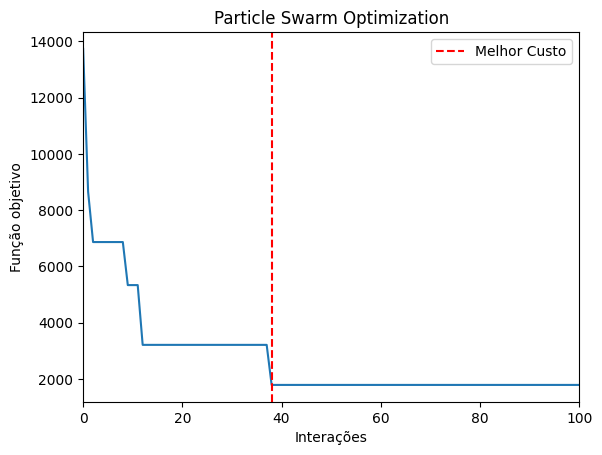


Cenário: primeiro_cenario
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
Melhor Custo: R$ 1.790,45
Número de Iterações até o Melhor Custo: 39
Tempo de Convergência para a segunda etapa: 1.4786033630371094 segundos


In [378]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(cost_history)

# Calcule o tempo total de convergência
convergence_time_second_stage = end_time_second_stage - start_time_second_stage

# Localizando o índice da melhor interação
index_melhor_custo = cost_history.index(min(cost_history))

# Plotando a linha vertical
plt.axvline(index_melhor_custo, color='red', linestyle='--', label='Melhor Custo')


plt.xlabel('Interações')
plt.xlim(0, max_iterations)
plt.ylabel('Função objetivo')
# plt.ylim(0, 1500)
plt.title('Particle Swarm Optimization')
plt.legend()
plt.show()

print("")
print('Cenário:', CENARIO)
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("Melhor Custo:", melhorCusto)
print("Número de Iterações até o Melhor Custo:", numero_interacoes)
print("Tempo de Convergência para a segunda etapa:", convergence_time_second_stage, "segundos")

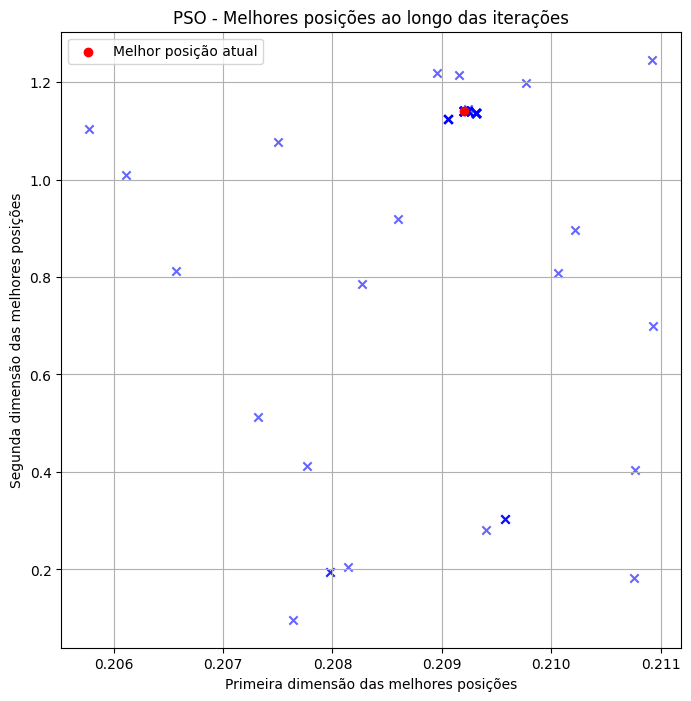

In [379]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()

In [380]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}.csv'

In [381]:
print(nome_arquivo)

/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_primeiro_cenario/melhor_custo_pso_primeiro_cenario.csv


In [382]:
# # Adicionar o melhor custo atual à lista de melhores custos anteriores
# melhores_custos_anteriores = []
# try:
#     with open(nome_arquivo, 'r') as arquivo_csv:
#         reader = csv.reader(arquivo_csv)
#         next(reader)  # Pule o cabeçalho
#         for linha in reader:
#             melhores_custos_anteriores.append(linha[1])
# except FileNotFoundError:
#     pass  # Arquivo não existe, pode ser a primeira execução

# melhores_custos_anteriores.append(melhorCusto)  # Substitua pbest_cost[0] por best_cost

# # Criar uma lista com os valores atuais
# valores_atuais = [len(melhores_custos_anteriores), melhorCusto, convergence_time_second_stage,]

# # Abrir o arquivo CSV em modo de leitura e escrita e escrever os valores atuais no final do arquivo
# with open(nome_arquivo, 'a+', newline='') as arquivo_csv:
#     writer = csv.writer(arquivo_csv)

#     # Se o arquivo estiver vazio, escreva o cabeçalho
#     if arquivo_csv.tell() == 0:
#         writer.writerow(['Index', 'Melhor_Custo', 'Convergencia_Segunda_Etapa', 'Ciclos_MP'])

#     # Escrever os valores atuais
#     writer.writerow(valores_atuais)

In [383]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
resultado = pd.read_csv(nome_arquivo, sep=",")
resultado.head(10)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/Resultados_primeiro_cenario/melhor_custo_pso_primeiro_cenario.csv'

In [ ]:
resultado.info()

In [ ]:
resultado.describe()

In [ ]:
param_segunda_etapa = ['Ciclos_MP', 'Melhor_Custo']
convergencia = ['Convergencia_Primeira_Etapa', 'Convergencia_Segunda_Etapa']
Melhor_Custo = ['Melhor_Custo']
Convergencia_Primeira_Etapa = ['Convergencia_Primeira_Etapa']
Convergencia_Segunda_Etapa = ['Convergencia_Segunda_Etapa']
Ciclos_MP = ['Ciclos_MP']

In [ ]:
# # Cria uma grafico para os parameros da segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(param_segunda_etapa):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 3 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [ ]:
# # Cria uma grafico para comparar as convervencias da primeira e segunda etapa
# # Tamanho da figura
# plt.figure(figsize=(8, 5))

# # Itera sobre as colunas e cria um boxplot para cada uma
# for i, coluna in enumerate(convergencia):
#     plt.subplot(1, 2, i + 1)  # 1 linhas, 2 colunas de gráficos
#     plt.boxplot(resultado[coluna])
#     plt.title(coluna)
#     plt.ylabel('Valores')

# # Ajusta o layout
# plt.tight_layout()
# plt.show()

In [ ]:
# Arrays de tempos e severidade
Tempos = [
[[303]],
[[336]],
[[272]],
[[62]],
[[517]],
[[364]],
[[332]],
[[360]],
[[395]],
[[303]],
]

severidade = [
    [[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
[[0.5]],
]

# Verifica se ambos os arrays têm o mesmo número de linhas
if len(Tempos) == len(severidade):
    with open(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', "w") as file:
        file.write('Tempos_Manutencoes_Preventivas;Severidade_subsistema\n')
        for i in range(len(Tempos)):
            row = Tempos[i] + severidade[i]
            row_str = [str(value) for value in row]
            file.write(f"{i};{';'.join(row_str)}\n")
else:
    print("Os arrays têm números diferentes de linhas e não podem ser concatenados.")

In [ ]:
# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
dados = pd.read_csv(f'{LINK_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_PRINCIPAL}{NOME_ARQUIVO_TEMPO_SEVERIDADE}.csv', sep=";")
dados.head(10)

In [ ]:
dados.info()

In [ ]:
dados.describe()